In [1]:
# creat all figures
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import matplotlib.patches as mpatches
from matplotlib import rc
# import latex
rc("text", usetex=False)

Plot RMSE from cross validation

In [2]:
%load_ext autoreload
%autoreload 2
from basic.plot import plot_error_cv

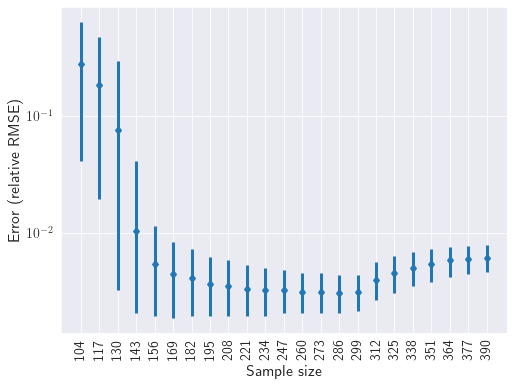

In [4]:
# Plot errors of cross-validation
filepath = '../output/paper0915/'
filename = 'error_cv_beta_552.csv'
error_stats = pd.read_csv(f'{filepath}{filename}', index_col = 'index')
cols = error_stats.columns
error_stats.loc[:, cols[1]] = error_stats.loc[:, cols[0]] - error_stats.loc[:, cols[1]]
error_stats.loc[:, cols[2]] = error_stats.loc[:, cols[2]] - error_stats.loc[:, cols[0]]  
plot_error_cv(error_stats, save_fig = False, save_path = f'{filepath}figure/',      fig_name = filename.split('.')[0], log_scale = True)

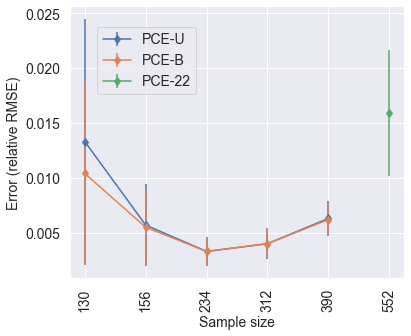

In [48]:
# Plot errors of cross-validation
from matplotlib import rcParams

filepath = '../output/paper0915/'
filename = 'error_cv_uniform_552.csv'
error_stats = pd.read_csv(f'{filepath}{filename}', index_col = 'index')
cols = error_stats.columns
error_stats.loc[:, cols[1]] = error_stats.loc[:, cols[0]] - error_stats.loc[:, cols[1]]
error_stats.loc[:, cols[2]] = error_stats.loc[:, cols[2]] - error_stats.loc[:, cols[0]]  
df_uniform = error_stats.iloc[[3, 4, 10, 16, 22]]
df_uniform.rename(columns={col: col+'_uni' for col in cols}, inplace=True)

filename = 'error_cv_beta_552.csv'
error_stats = pd.read_csv(f'{filepath}{filename}', index_col = 'index')
cols = error_stats.columns
error_stats.loc[:, cols[1]] = error_stats.loc[:, cols[0]] - error_stats.loc[:, cols[1]]
error_stats.loc[:, cols[2]] = error_stats.loc[:, cols[2]] - error_stats.loc[:, cols[0]]  
df_beta = error_stats.iloc[[3, 4, 10, 16, 22]]
df_beta.rename(columns={col: col+'_beta' for col in cols}, inplace=True)

df = pd.concat([df_uniform, df_beta], axis=1)

filename = 'error_cv_compare.csv'
error_stats = pd.read_csv(f'{filepath}{filename}').iloc[0]
df.loc['nsample_552', 'mean_22_uni'] = error_stats['mean']
# df.loc['nsample_552', 'mean_22_uni'] = error_stats['mean']
df.loc['nsample_552', 'lower_22_uni'] = error_stats['mean'] - error_stats['lower']
df.loc['nsample_552', 'upper_22_uni'] = error_stats['upper'] - error_stats['mean']

df_cols = df.columns
legend = [df_cols[i] for i in range(len(df_cols)) if (i % 3) ==0]
legend_low = [df_cols[i] for i in range(len(df_cols)) if (i % 3) ==1]
legend_up = [df_cols[i] for i in range(len(df_cols)) if (i % 3) ==2]

df = df.reset_index()
df.plot(x='index', y=legend, kind='line', figsize=(6,5), marker='d',
                yerr=df.loc[:, [*legend_low, *legend_up]].T.values, 
                legend=True, logy=False, xticks=np.arange(df.shape[0]))

plt.xticks(ticks = np.arange(df.shape[0]), labels = [130, 156, 234, 312, 390, 552], fontsize = 14, rotation=90);
rcParams['ytick.labelsize'] = 14
plt.legend(['PCE-U', 'PCE-B', 'PCE-22'], bbox_to_anchor=(0.4, 0.95), fontsize=14)
plt.ylabel('Error (relative RMSE)', fontsize = 14);
plt.xlabel('Sample size', fontsize = 14);
plt.savefig(f'{filepath}/figure/pce_compare.png', format='png', dpi=300)

In [24]:
# check whether the increase of error is of significance
filepath = '../output/paper0915/'
dist_type = 'uniform'
filename = f'adaptive-reduce-{dist_type}_552.npz'

fileread = np.load(f'{filepath}{filename}', allow_pickle=True)
errors_cv = fileread[fileread.files[0]][()]
sensitivity_indices = fileread[fileread.files[1]][()]
# Look the error change with the increase of sample size
errors_cv = pd.DataFrame.from_dict(errors_cv)
errors_cv

,nsample_104,nsample_117,nsample_130,nsample_143,nsample_156,nsample_169,nsample_182,nsample_195,nsample_208,nsample_221,...,nsample_273,nsample_286,nsample_299,nsample_312,nsample_325,nsample_338,nsample_351,nsample_364,nsample_377,nsample_390
0,0.256221,0.063316,0.171276,0.007236,0.006323,0.004816,0.006114,0.002250,0.005742,0.003748,...,0.004087,0.002783,0.002752,0.003797,0.004680,0.003777,0.004815,0.006374,0.006217,0.004615
1,0.124287,0.074478,0.141030,0.006191,0.005343,0.003806,0.005368,0.002270,0.004404,0.003429,...,0.003646,0.001918,0.003752,0.002811,0.004110,0.003912,0.004842,0.004437,0.006119,0.006573
2,0.280137,0.009357,0.028008,0.005417,0.007512,0.005664,0.004090,0.004595,0.004082,0.002237,...,0.002432,0.003877,0.003159,0.002859,0.004624,0.004736,0.006767,0.006561,0.006608,0.006400
3,0.099217,0.084066,0.134142,0.005573,0.003101,0.004171,0.004229,0.003952,0.003853,0.004367,...,0.003141,0.003278,0.002242,0.004140,0.005102,0.005482,0.006208,0.006988,0.005985,0.006227
4,0.159991,0.040333,0.173146,0.003325,0.005319,0.003526,0.003101,0.003466,0.003266,0.003807,...,0.003191,0.003692,0.004386,0.002659,0.004844,0.007752,0.004888,0.006531,0.005792,0.007914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.076009,0.170759,0.300146,0.009952,0.003575,0.004126,0.004094,0.003955,0.003713,0.003422,...,0.003217,0.002716,0.003401,0.003706,0.005473,0.004885,0.004770,0.006150,0.008150,0.007154
4996,0.573710,0.168419,0.115980,0.009790,0.004925,0.006339,0.007582,0.002739,0.003255,0.003228,...,0.002305,0.002147,0.003894,0.005358,0.004399,0.005012,0.004312,0.005835,0.004424,0.005429
4997,0.074839,0.203362,0.076269,0.003201,0.006547,0.004705,0.002421,0.004158,0.003405,0.004384,...,0.002778,0.003120,0.002379,0.003341,0.005812,0.003583,0.007401,0.006250,0.006610,0.004718
4998,0.240511,0.165063,0.163651,0.006530,0.006266,0.003188,0.004916,0.002079,0.006462,0.002365,...,0.002594,0.002985,0.002236,0.004280,0.006107,0.005623,0.006211,0.005802,0.005538,0.006594


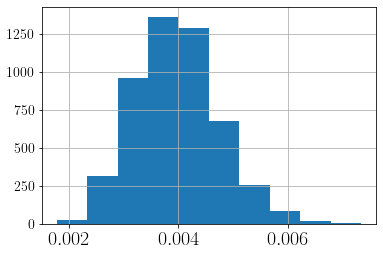

In [27]:
errors_cv.loc[:, 'nsample_312'].hist()

Bar plot of sensitivity indices

In [29]:
# sensitivity plot
filepath = '../output/paper/'
df_plot = pd.read_csv(f'{filepath}sa_fig2.csv', index_col= 'Unnamed: 0')

sns.set_style('white')
current_palette = sns.color_palette()
# sns.set_color_codes(current_palette)
fig = plt.figure(figsize=(8, 6))
colors = list(np.where(df_plot.Type_num == 0, 0, 2))
colors = [current_palette[c] for c in colors]
ax = df_plot.plot(x='short_name', y='ST', kind='bar', 
                yerr='ST_conf', color=colors, legend=False, logy=False)
ax.set_ylabel('Total effects', fontsize=10)
ax.set_xlabel('Parameters', fontsize=10)
ax.tick_params(axis='x', which='major', labelsize=8)
index = [0, 20, 28]
xmin, ymin = [-0.3, 19.5, 27.5], 0
height, width = 0.79, [9.8, 3, 3]
for i  in range(len(index)):
    ax.add_patch(
        mpatches.Rectangle(
            xy=(xmin[i], ymin),  # point of origin.
            width=width[i],
            height=height,
            linewidth=1,
            color=current_palette[1],
            fill=False,
            linestyle='--'
        )
)   
SPL = mpatches.Patch(color=current_palette[0], label='Sampling')
PCE_Beta = mpatches.Patch(color=current_palette[2], label='PCE')
ax.legend(handles=[SPL, PCE_Beta], fontsize=8, loc=9) 
# plt.savefig(f'{filepath}figure/sentivity_fig1.png', format='png', dpi=300, bbox_inches='tight')

AttributeError: 'DataFrame' object has no attribute 'Type_num'

In [50]:
df_plot

,Parameters,ST,ST_conf_lower,ST_conf_upper,ST_Beta,ST_Beta_conf_lower,ST_Beta_conf_upper,ST_Uniform,ST_Uniform_conf_lower,ST_Uniform_conf_upper,short_name
0,bankErosionCoeff,0.621704,0.059881,0.061024,0.616205,0.007981,0.009458,0.870492,0.012857,0.012030,BEC-R
7,Beta,0.209298,0.025889,0.027194,0.207556,0.006839,0.007490,0.047646,0.006924,0.006575,Beta
3,RiparianVegPercent,0.069010,0.009944,0.011385,0.066703,0.003752,0.004071,0.052183,0.006513,0.006830,RVP
2,HillslopeFineSDR,0.047440,0.006181,0.006898,0.046282,0.003168,0.003611,0.016259,0.003610,0.004218,HFSDR-R
4,USLE_HSDR_Fine,0.041086,0.005565,0.006151,0.041181,0.002766,0.003136,0.009188,0.001998,0.002020,USLEHF
8,LongTermAvDailyFlow,0.018078,0.003256,0.003805,0.018440,0.002026,0.002458,0.015110,0.003483,0.003706,LTADF
1,eventMeanConcentration,0.015176,0.002801,0.003189,0.014956,0.001890,0.002290,0.003472,0.000970,0.001225,EMC
6,RainThreshold,0.000798,0.000357,0.000576,0.000803,0.000361,0.000554,0.000218,0.000135,0.000368,RT
5,A3,0.000344,0.000244,0.000505,0.000361,0.000248,0.000557,0.000190,0.000153,0.000378,A3
9,Gully_Management_Practice_Factor,0.000314,0.000230,0.000498,0.000320,0.000225,0.000592,0.000247,0.000199,0.000598,GMPF-R


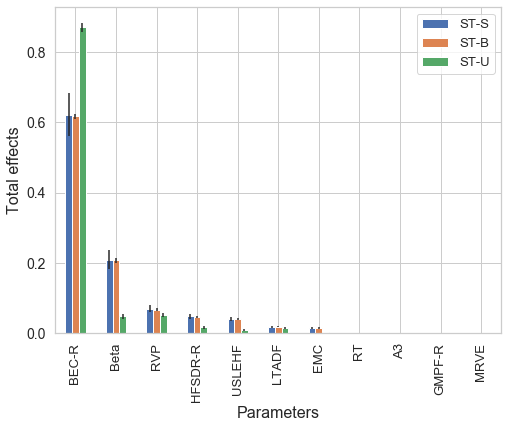

In [49]:
# plot sensitivity for PCE with 11 parameters of Beta, Uniform dists
filepath = '../output/paper0915/'
df_plot = pd.read_csv(f'{filepath}sa_fig2.csv', index_col= 'Unnamed: 0')
cols = df_plot.columns
legend = ['ST', 'ST_Beta', 'ST_Uniform']
legend_low = [lab+'_conf_lower' for lab in legend]
legend_up = [lab+'_conf_upper' for lab in legend]
for lab in legend:
    df_plot.loc[:, f'{lab}_conf_lower'] = df_plot.loc[:, lab] - df_plot.loc[:, f'{lab}_conf_lower'] 
    df_plot.loc[:, f'{lab}_conf_upper'] = df_plot.loc[:, f'{lab}_conf_upper'] - df_plot.loc[:, lab]

sns.set_style('whitegrid')
ax = df_plot.plot(x='short_name', y=legend, kind='bar', figsize=(8,6),
                yerr=df_plot.loc[:, [*legend_low, *legend_up]].T.values, 
                legend=True, logy=False, xticks=np.arange(df_plot.shape[0]))
ax.set_ylabel('Total effects', fontsize=16);
ax.set_xlabel('Parameters', fontsize=16); 
ax.set_xticklabels(df_plot.short_name.values, rotation=90);
ax.legend(['ST-S', 'ST-B', 'ST-U'])
# plt.savefig(f'{filepath}figure/Figure5-bar.png', format='png', dpi=300, bbox_inches='tight') 

In [8]:
df_plot

,Parameters,ST,ST_conf_lower,ST_conf_upper,ST_Beta,ST_Beta_conf_lower,ST_Beta_conf_upper,ST_Uniform,ST_Uniform_conf_lower,ST_Uniform_conf_upper,short_name
0,bankErosionCoeff,0.762550,0.099928,0.114356,0.759594,0.007180,0.006195,0.916264,0.007124,0.006454,new_BEC
3,RiparianVegPercent,0.085721,0.016571,0.017165,0.081979,0.003982,0.004238,0.054049,0.005774,0.006282,RVP
7,Beta,0.063841,0.011290,0.016928,0.062540,0.003493,0.003249,0.010991,0.001943,0.002280,Beta
4,USLE_HSDR_Fine,0.051351,0.008921,0.010443,0.052003,0.002840,0.003244,0.008928,0.001611,0.001836,USLEHF
8,LongTermAvDailyFlow,0.021809,0.004800,0.005501,0.022328,0.002341,0.002537,0.015533,0.002794,0.002902,LTADF
1,eventMeanConcentration,0.018327,0.003653,0.004227,0.018395,0.002125,0.002027,0.003321,0.000877,0.000982,EMC
2,HillslopeFineSDR,0.015537,0.003284,0.003620,0.015739,0.001800,0.002105,0.005837,0.001841,0.002282,new_HFSDR
6,RainThreshold,0.000891,0.000350,0.000502,0.000921,0.000345,0.000449,0.000175,0.000093,0.000261,RT
5,A3,0.000307,0.000213,0.000504,0.000292,0.000190,0.000387,0.000143,0.000116,0.000323,A3
9,Gully_Management_Practice_Factor,0.000303,0.000217,0.000443,0.000305,0.000212,0.000390,0.000176,0.000137,0.000406,new_GMPF


Heat Map plot

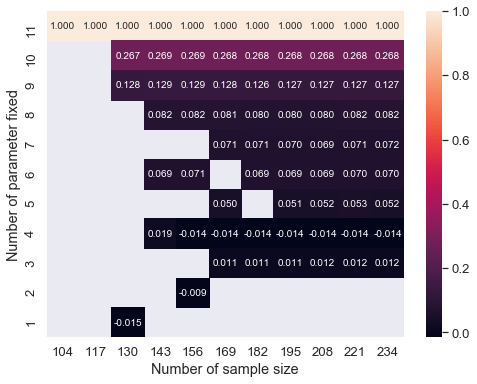

In [40]:
# heat map 
filepath = '../output/paper0915/error_measures/'
filename = 'cf_changes.csv'
df = pd.read_csv(f'{filepath}{filename}')
fpath_save = '../output/paper0915/figure/'
df.drop(columns={'Unnamed: 0'}, inplace=True)
sns.set(font_scale=1.2)
def plot_heatmap(df, save=False, save_name=None):    
    df.index = np.arange(df.shape[0], 0, -1)
    df = df.rename(columns={col: col.split('_')[1] for col in df.columns})
    fig = plt.figure(figsize=(8, 6))
    ax = sns.heatmap(df.loc[:, df.columns[0:]], annot=True, fmt=".3f", annot_kws={"size": 10})
    ax.set_xlabel('Number of sample size')
    ax.set_ylabel('Number of parameter fixed')
    if save:
        plt.savefig(f'{fpath_save}{save_name}.png', format='png', dpi=300)
plot_heatmap(df, save=False, save_name=filename.split('.')[0])

In [38]:
# calculate the changes in the confidence intervals
# heat map 
filepath = '../output/paper0915/error_measures/'
filename = ['cf_width', 'cf_width_lower', 'cf_width_upper']
df_mean = pd.read_csv(f'{filepath}{filename[0]}.csv', index_col = 'Unnamed: 0')
df_lower = pd.read_csv(f'{filepath}{filename[1]}.csv', index_col = 'Unnamed: 0')
df_upper = pd.read_csv(f'{filepath}{filename[2]}.csv', index_col = 'Unnamed: 0')
df_lower = 1 - df_lower
cols = df_mean.columns
for col in cols:
    ind = df_mean[df_mean[col]>1].index.tolist()
    print(ind)
    if len(ind) > 0: df_lower.loc[ind, col] = 1 - df_upper.loc[ind, col]
df_lower.to_csv(f'{filepath}cf_changes.csv', index=True)

[]
[]
[1]
[]
[4, 3, 2, 1]
[4]
[4]
[4]
[4]
[4]
[4]


In [36]:
df_mean>1

,nsample_104,nsample_117,nsample_130,nsample_143,nsample_156,nsample_169,nsample_182,nsample_195,nsample_208,nsample_221,nsample_234
11,False,False,False,False,False,False,False,False,False,False,False
10,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,True,True,True,True,True,True
3,False,False,False,False,True,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,False


In [35]:
df_lower - df_upper

,nsample_104,nsample_117,nsample_130,nsample_143,nsample_156,nsample_169,nsample_182,nsample_195,nsample_208,nsample_221,nsample_234
11,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-2.868763e-18,0.000000,0.000000,0.000000
10,0.0,0.0,0.004246,0.003813,0.004386,0.002900,0.003246,4.110631e-03,0.003774,0.002620,0.002721
9,0.0,0.0,0.003070,0.002300,0.003384,0.002398,0.001357,2.381380e-03,0.002591,0.002052,0.002020
8,0.0,0.0,0.003070,0.006043,0.008346,0.007236,0.006787,7.630950e-03,0.006671,0.006577,0.006709
7,0.0,0.0,0.003070,0.006043,0.008346,0.003096,0.002790,2.392843e-03,0.002613,0.002375,0.003174
6,0.0,0.0,0.003070,-0.000669,0.004017,0.001603,0.001402,1.645744e-03,0.001915,0.000791,0.001277
5,0.0,0.0,0.003070,-0.000669,0.004017,0.001164,0.001402,-2.890656e-04,-0.000008,-0.000329,-0.002201
4,0.0,0.0,0.003070,0.003070,0.001952,0.001669,0.001841,2.842194e-03,0.002867,0.002133,0.002035
3,0.0,0.0,0.003070,0.003070,0.001952,-0.000801,-0.003255,-2.671775e-03,-0.001121,-0.001819,-0.001678
2,0.0,0.0,0.003070,0.003070,-0.002070,-0.000801,-0.003255,-2.671775e-03,-0.001121,-0.001819,-0.001678


Line plot for three error measures

In [3]:
# prepare the data for plot: confidence intervals and the coefficient of variation
filepath = '../output/paper0915/error_measures/'
filename = ['cf_upper', 'cf_lower', 'cv', 'ks', 'pvalue', 'cf_upper_upper', 
'cf_upper_lower', 'cf_lower_upper', 'cf_lower_lower',
'ks_lower', 'ks_upper', 'pvalue_lower', 'pvalue_upper', 'cond_mean']
# read statistics from the file y_uncond_stats.json
# with open(f'{filepath}y_uncond_stats.json', 'r') as fp: y_uncond_stat = json.load(fp)

# get data in the corresponding column
num_params = 11
col_filter = ['nsample_156']
df = pd.DataFrame(index=np.arange(num_params), columns=filename)
x_range = [0, num_params + 1]
for f in filename:
    df[f] = pd.read_csv(f'{filepath}{f}.csv').loc[:, col_filter]
df.index = np.arange(df.shape[0], 0, -1)
df.index.name = 'Num of parameters fixed'
df.reset_index(inplace=True)
# add the one with no parameter fixed
# df.loc[11, :] = [0, y_uncond_stat['cf_upper'], y_uncond_stat['cf_lower'], 
#                 y_uncond_stat['cv'], 1, 0, 1]

In [4]:
# add the relative change of CIs formed as the deviation to median
cf_median = (df.loc[:, 'cf_upper'] + df.loc[:, 'cf_lower']) / 2
df.loc[:, 'upper_mean'] = (df.cf_upper - df.cond_mean) / df.cond_mean
df.loc[:, 'upper_mean_lower'] = (df.cf_upper_lower - df.cond_mean) / df.cond_mean
df.loc[:, 'upper_mean_upper'] = (df.cf_upper_upper - df.cond_mean) / df.cond_mean
df.loc[:, 'lower_mean'] = (df.cond_mean - df.cf_lower) / df.cond_mean
df.loc[:, 'lower_mean_lower'] = (df.cond_mean - df.cf_lower_lower) / df.cond_mean
df.loc[:, 'lower_mean_upper'] = (df.cond_mean - df.cf_lower_upper) / df.cond_mean
df.loc[:, 'cf_median_mean'] = (cf_median - df.cf_lower) / cf_median
df.loc[:, 'cf_median_lower'] = (cf_median - df.cf_lower_lower) / cf_median
df.loc[:, 'cf_median_upper'] = (cf_median - df.cf_lower_upper) / cf_median
df.loc[:, 'cf_cv'] = 2 * df['cv']

In [5]:
df

,Num of parameters fixed,cf_upper,cf_lower,cv,ks,pvalue,cf_upper_upper,cf_upper_lower,cf_lower_upper,cf_lower_lower,...,upper_mean,upper_mean_lower,upper_mean_upper,lower_mean,lower_mean_lower,lower_mean_upper,cf_median_mean,cf_median_lower,cf_median_upper,cf_cv
0,11,2.774412e+07,2.774412e+07,0.000000,0.569949,9.313839e-128,2.774412e+07,2.774412e+07,2.774412e+07,2.774412e+07,...,5.370927e-16,0.000000,0.000000,-5.370927e-16,0.000000,0.000000,0.000000,5.370927e-16,5.370927e-16,0.000000
1,10,3.551139e+07,2.268334e+07,0.073226,0.125373,5.245996e-06,3.619039e+07,3.480993e+07,2.281706e+07,2.250628e+07,...,1.189256e-01,0.096823,0.140320,2.852724e-01,0.290851,0.281059,0.220433,2.265182e-01,2.158377e-01,0.146452
2,9,3.550482e+07,2.026505e+07,0.109705,0.052779,1.585812e-01,3.609822e+07,3.478045e+07,2.073815e+07,1.977936e+07,...,2.242446e-01,0.199267,0.244706,3.012391e-01,0.317986,0.284926,0.273262,2.906793e-01,2.562956e-01,0.219411
3,8,3.595229e+07,2.016846e+07,0.124674,0.043543,3.312289e-01,3.693637e+07,3.533969e+07,2.076918e+07,1.968614e+07,...,1.745847e-01,0.154571,0.206735,3.410833e-01,0.356841,0.321457,0.281248,2.984362e-01,2.598395e-01,0.249349
4,7,3.595229e+07,2.016846e+07,0.124674,0.043543,3.312289e-01,3.693637e+07,3.533969e+07,2.076918e+07,1.968614e+07,...,1.745847e-01,0.154571,0.206735,3.410833e-01,0.356841,0.321457,0.281248,2.984362e-01,2.598395e-01,0.249349
5,6,3.588195e+07,2.008802e+07,0.142293,0.027447,8.246941e-01,3.697010e+07,3.513454e+07,2.048566e+07,1.960875e+07,...,3.227124e-01,0.295160,0.362825,2.594977e-01,0.277165,0.244840,0.282186,2.993119e-01,2.679769e-01,0.284586
6,5,3.588195e+07,2.008802e+07,0.142293,0.027447,8.246941e-01,3.697010e+07,3.513454e+07,2.048566e+07,1.960875e+07,...,3.227124e-01,0.295160,0.362825,2.594977e-01,0.277165,0.244840,0.282186,2.993119e-01,2.679769e-01,0.284586
7,4,3.616092e+07,1.996028e+07,0.157008,0.014235,9.994658e-01,3.738695e+07,3.526985e+07,2.045240e+07,1.951941e+07,...,3.349397e-01,0.302044,0.380200,2.631335e-01,0.279409,0.244966,0.288672,3.043839e-01,2.711347e-01,0.314015
8,3,3.616092e+07,1.996028e+07,0.157008,0.014235,9.994658e-01,3.738695e+07,3.526985e+07,2.045240e+07,1.951941e+07,...,3.349397e-01,0.302044,0.380200,2.631335e-01,0.279409,0.244966,0.288672,3.043839e-01,2.711347e-01,0.314015
9,2,3.614865e+07,1.995291e+07,0.156195,0.011246,9.999682e-01,3.739762e+07,3.521146e+07,2.047219e+07,1.949056e+07,...,3.206471e-01,0.286408,0.366277,2.710445e-01,0.287936,0.252074,0.288686,3.051688e-01,2.701741e-01,0.312390


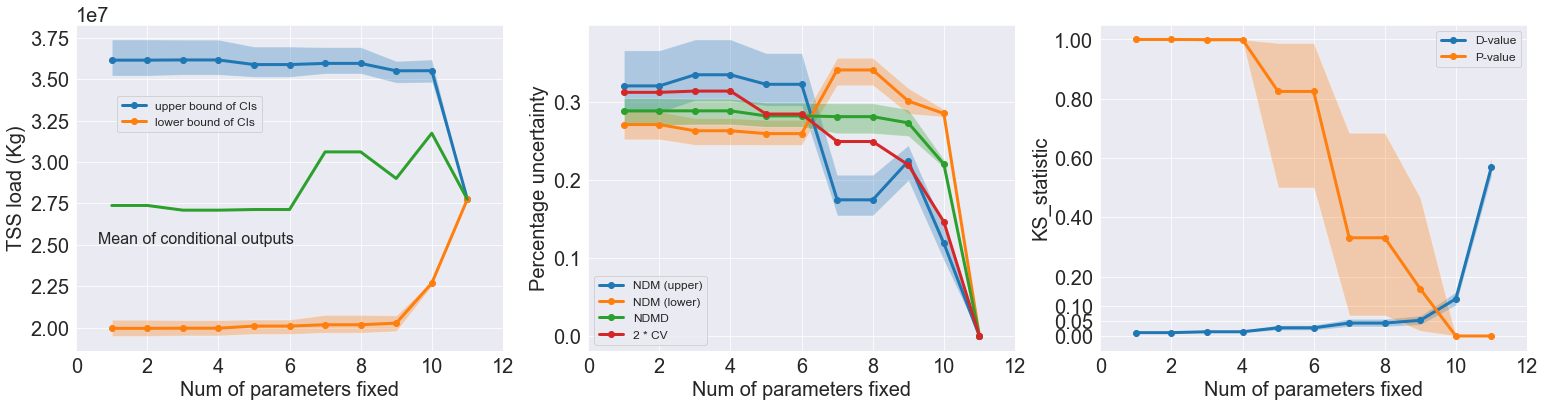

In [11]:
# Line plot
plt.rcParams["text.usetex"] = False
sns.set_style('darkgrid')
fs = 12
fig, axes = plt.subplots(1, 3, sharex=True)
x_col = 'Num of parameters fixed'
ax = df.plot(x=x_col, y=filename[0:2], 
            figsize=(26, 6), marker='o', ax=axes[0])
ax.fill_between(df.loc[:, x_col], df.cf_upper_lower, df.cf_upper_upper, alpha=0.3)
ax.fill_between(df.loc[:, x_col], df.cf_lower_lower, df.cf_lower_upper, alpha=0.3)            
             
ax.plot(df.loc[:, x_col], df.cond_mean)          
# ax.axhline(c='grey',linestyle='--', y=y_uncond_stat['cf_upper']) 
ax.text(0.05, 0.33, 'Mean of conditional outputs', transform=ax.transAxes) #c='k',

ax.set_ylabel('TSS load (Kg)')
ax.legend(['upper bound of CIs', 'lower bound of CIs'], fontsize=fs, bbox_to_anchor=(0.45, 0.8))

ax1 = df.plot(x_col, ['upper_mean', 'lower_mean', 'cf_median_mean', 'cf_cv'], marker='o', ax=axes[1])
ax1.fill_between(df.loc[:, x_col], df.upper_mean_lower, df.upper_mean_upper, alpha=0.3)
ax1.fill_between(df.loc[:, x_col], df.lower_mean_lower, df.lower_mean_upper, alpha=0.3)
ax1.fill_between(df.loc[:, x_col], df.cf_median_lower, df.cf_median_upper, alpha=0.3)
ax1.set_ylabel('Percentage uncertainty') 
ax1.legend(['NDM (upper)', 'NDM (lower)', 'NDMD', '2 * CV'], fontsize=fs)

ax2 = df.plot(x_col,['ks', 'pvalue'], marker='o', ax=axes[2])
ax2.fill_between(df.loc[:, x_col], df.ks_lower, df.ks_upper, alpha=0.3)
ax2.fill_between(df.loc[:, x_col], df.pvalue_lower, df.pvalue_upper, alpha=0.3)
ax2.set_xlim(*x_range)
ax2.set_yticks([0, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_ylabel('KS_statistic')
ax2.legend(['D-value', 'P-value'], fontsize=fs) ;
ax2.set_xlabel(x_col);
fpath_save = '../output/paper0915/figure/'
plt.savefig(f'{fpath_save}/figure7_uncertainty_communication.png', format='png', dpi=300, bbox_inches='tight')

Line plot for showing robustness of error estimation

In [14]:
# Adaptive evaluation of error measure
filepath = '../output/paper0915/error_measures/'
filename = ['cf_lower_adaptive', 'cf_lower_lower_adaptive', 'cf_lower_upper_adaptive',
            'cf_upper_adaptive', 'cf_upper_lower_adaptive', 'cf_upper_upper_adaptive',             'stats_uncond_adaptive']

In [15]:
# sort the dataframe for plot
df = pd.DataFrame()
for fn in filename[:-1]:
    df[fn] = pd.read_csv(f'{filepath}{fn}.csv', index_col = 'Unnamed: 0').iloc[1]
df.loc[:, 'median'] = (df.loc[:, filename[0]] + df.loc[:, filename[3]]) / 2 # only use the mean of CIs for calculation
cols = df.columns

In [5]:
df

,cf_lower_adaptive,cf_lower_lower_adaptive,cf_lower_upper_adaptive,cf_upper_adaptive,cf_upper_lower_adaptive,cf_upper_upper_adaptive,median
1000,2.207408e+07,2.193351e+07,2.224104e+07,3.518637e+07,3.430593e+07,3.592200e+07,2.863023e+07
1500,2.199612e+07,2.174389e+07,2.217457e+07,3.510876e+07,3.433855e+07,3.595990e+07,2.855244e+07
2000,2.198533e+07,2.185218e+07,2.211814e+07,3.486715e+07,3.441370e+07,3.532575e+07,2.842624e+07
2500,2.203432e+07,2.186901e+07,2.216856e+07,3.485498e+07,3.454905e+07,3.524810e+07,2.844465e+07
3000,2.196812e+07,2.181989e+07,2.214111e+07,3.491663e+07,3.465268e+07,3.535883e+07,2.844237e+07
3500,2.199756e+07,2.188835e+07,2.211567e+07,3.455879e+07,3.430500e+07,3.488578e+07,2.827818e+07
4000,2.201296e+07,2.186744e+07,2.214184e+07,3.514839e+07,3.488201e+07,3.547215e+07,2.858068e+07
4500,2.204381e+07,2.193657e+07,2.213337e+07,3.482064e+07,3.460303e+07,3.512531e+07,2.843222e+07
5000,2.208322e+07,2.197188e+07,2.219098e+07,3.480525e+07,3.442523e+07,3.508025e+07,2.844423e+07
5500,2.206165e+07,2.199310e+07,2.214018e+07,3.490465e+07,3.462693e+07,3.527401e+07,2.848315e+07


In [16]:
df_ratio = pd.DataFrame(index=df.index, columns=df.columns)
for fn in filename[:-1]:
    if 'cf_lower' in fn:
        df_ratio.loc[:, fn] = (df.loc[:, cols[-1]] - df.loc[:, fn]) / df.loc[:, cols[-1]]
    else:
        df_ratio.loc[:, fn] = (df.loc[:, fn] - df.loc[:, cols[-1]]) / df.loc[:, cols[-1]]
df_ratio.loc[:, cols[-1]] = df.loc[:,cols[-1]]

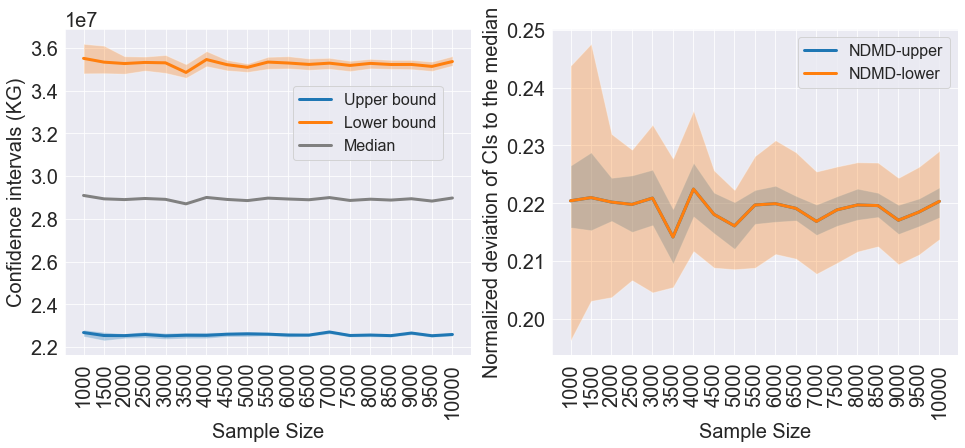

In [17]:

plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(1, 2)
ax = df[cols[[0, 3]]].plot(figsize=(16, 6), ax=axes[0])
plt.sca(axes[0])
df[cols[-1]].plot(ax=ax, color='grey')
plt.xticks(range(len(df.index)), df.index, rotation=90)
ax.fill_between(df.index, df[cols[1]], df[cols[2]], alpha=0.3)
ax.fill_between(df.index, df[cols[4]], df[cols[5]], alpha=0.3)
ax.set_xlabel('Sample Size');
ax.set_ylabel('Confidence intervals (KG)');
ax.legend(['Upper bound', 'Lower bound', 'Median'], bbox_to_anchor=[0.95, 0.85])

ax1 = df_ratio[cols[[0, 3]]].plot(ax=axes[1])
plt.sca(axes[1])
plt.xticks(range(len(df_ratio.index)), df_ratio.index, rotation=90)
ax1.fill_between(df.index, df_ratio[cols[1]], df_ratio[cols[2]], alpha=0.3)
ax1.fill_between(df.index, df_ratio[cols[4]], df_ratio[cols[5]], alpha=0.3)
ax1.set_xlabel('Sample Size');
ax1.set_ylabel('Normalized deviation of CIs to the median');
ax1.legend(['NDMD-upper', 'NDMD-lower']);
plt.savefig('../output/paper/figure/'+'conf_adaptive_two_panels.png', format='png', dpi=300, layout='tight')